# Adaptive Optics

This code is written by Mutian Wang, from Nanjing University in China, during an internship in the University of Sydney in Australia from July to August,2019, under the guidance of my supervisors: Prof. Peter Tuthill and Dr. Barnaby Norris.

This code is used to generate coronagraphic images in the presence of AO. A classical Lyot Coronagraph with focal mask and Lyot Stop is applied.

In [2]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit as timeit
import time
import math as math
from astropy.io import fits
%matplotlib inline

In [4]:
def field2array(field, filename):
    [dim1,dim2] = field.grid.dims
    data = np.zeros((dim1,dim2))

    for y_index in np.linspace(0,dim2,dim2,endpoint=False):
        for x_index in np.linspace(0,dim1,dim1,endpoint=False):
            index = x_index * dim1 + y_index
            data[int(x_index),int(y_index)] = field[int(index)]
    if filename is None:
        return data
    else:
        fits.writeto(filename=filename,data=data)
    

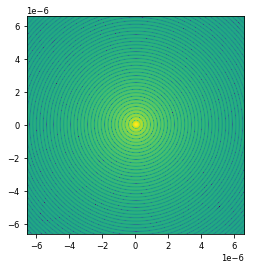

In [5]:

D = 8 #Diameter of the aperture, unit: meter
wavelength = 1.65e-6
pupil_grid = make_pupil_grid(1024,D) #1024 pix in each dimension
focal_grid = make_focal_grid_from_pupil_grid(num_airy = 32, pupil_grid = pupil_grid, q = 16, wavelength= wavelength )
prop = FraunhoferPropagator(pupil_grid, focal_grid)
wf_ref = Wavefront(circular_aperture(D)(pupil_grid), wavelength)
wf = Wavefront(Field(np.ones(pupil_grid.size), pupil_grid), wavelength)
imshow_field(np.log10(prop(wf_ref).intensity))


In [4]:
detector = NoiselessDetector()
detector_ref = NoiselessDetector()

Now construct the focal mask and lyot stop. The focal mask is set on the focal plane, so the real size of focal mask will be determined by percentage of the obscuration and range of airy rings you decided to show up in previous settings, in this example I decide to show 32 airy rings, so 10% obscuration means that the focal mask is 3.2 $\lambda/D$ in radius

The lyot stop undersize will not affected by the focal plane settings.

focal mask radius: 3.2 lambda/D
lyot stop size: 90%, 30%


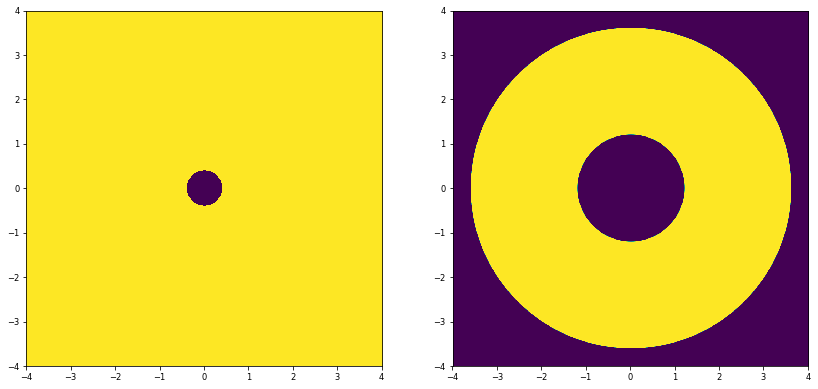

In [5]:
input_grid = pupil_grid
central_obscuration = 0.10 * D
lyot_stop_size = 0.9* D

#making lyot-plane mask
mask = circular_aperture(central_obscuration)
mask = evaluate_supersampled(mask,input_grid,8)

for i in range(mask.size):
    if mask[i] == 1:
        mask[i] = 0
    else:
        mask[i] = 1   
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
imshow_field(mask)
mask = Apodizer(mask)
    
#making lyot stop
lyot_stop = lambda grid: circular_aperture(lyot_stop_size)(grid) - circular_aperture(0.3 * D)(grid)
lyot_stop = evaluate_supersampled(lyot_stop, input_grid, 8)

plt.subplot(1,2,2)
imshow_field(lyot_stop)

lyot_stop = Apodizer(lyot_stop)

print('focal mask radius: 3.2 lambda/D' )
print('lyot stop size: 90%, 30%' )


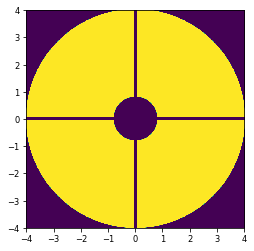

In [6]:
aperture = make_obstructed_circular_aperture(pupil_diameter=D,central_obscuration_ratio=0.2,num_spiders=4,spider_width=0.01 * D)
aperture = evaluate_supersampled(aperture, pupil_grid, 8)
imshow_field(aperture)

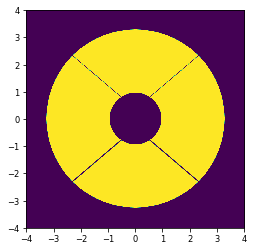

In [7]:
magellanic_aper = make_magellan_aperture(normalized=False)
magellanic_aper = evaluate_supersampled(magellanic_aper, pupil_grid, 16)
imshow_field(magellanic_aper)

Now let's add some surface aberration. This command line assumes the power spectra density follows a power law and will place phase errors onto the wavefront.

The `remove_modes` is the modes which to remove from the surface aberration. The peak-to-valley is enforced before these modes are removed. This allows for correctting surface errors with optic alignment.

/Users/neptune/hcipy/hcipy/optics/aberration.py:39: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


rms:29.083037728938272nm


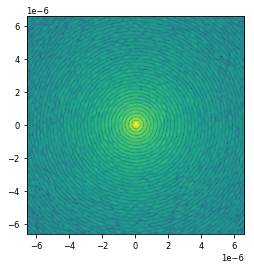

In [8]:
remove_modes = make_zernike_basis(25, D, pupil_grid, 1,use_cache=True)
aberration = SurfaceAberration(diameter=D,pupil_grid=pupil_grid,ptv=0.1 * wavelength, remove_modes=remove_modes,exponent=-2)
print('rms:'+str(1650 * np.sqrt(np.mean(np.square(aberration(wf).phase))) / (2*np.pi)) + 'nm')
imshow_field(np.log10(prop(aberration(wf_ref)).intensity))


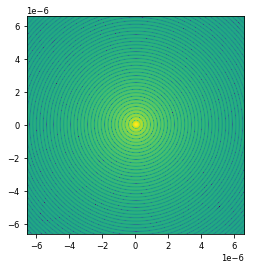

In [9]:
wf_ref.total_power = 1
img_ref = prop(wf_ref).intensity
#img_ref = Field(img_ref,focal_grid.scaled(D/wavelength))  if you want to show img in units of lambda/D

imshow_field(np.log10(img_ref))

Now is time to construct the atmosphere. You can construct infinite and thin atmosphere layer using `InfiniteAtmosphericLayer`. Fried parameter and the outer scale, stencil length can be changed. The velocity can be either scalar or vector. If a scalar is put in, it will randomly set a direction to it.

`ModalAdaptiveOptics` simulate the AO-corrected atmosphere layer. It does not involve any real AO designation(choices of DM, WFS, etc.) All it do is to mitigate the phase errors when light travels through. 

You can construct multiple layers and use `MultilayerAtmosphere` to combine them altogether. Just remember to reset the Cn profile after the compilation, if you want to maintain a good strehl ratio during the evolving of the atmosphere.

Constructing mode basis has cost:
CPU times: user 45.5 s, sys: 11 s, total: 56.4 s
Wall time: 18.5 s


Constructing single atmosphere layer has cost:
CPU times: user 37.8 s, sys: 1.36 s, total: 39.2 s
Wall time: 20 s
CPU times: user 4min 27s, sys: 52.2 s, total: 5min 19s
Wall time: 1min 24s


Constructing multi-layer atmosphere layer has cost:
CPU times: user 135 µs, sys: 766 µs, total: 901 µs
Wall time: 2.01 ms


Evolving the atmosphere from 0s to 0.02s has cost:
CPU times: user 3.65 s, sys: 6.7 s, total: 10.3 s
Wall time: 2.57 s


rms:228.8120673897889nm
rms:0.8713143151084285rad**2
The Strehl ratio is 0.9378451326573625
CPU times: user 11min 17s, sys: 2min 18s, total: 13min 35s
Wall time: 3min 55s


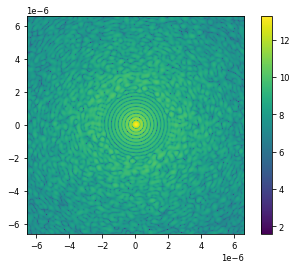

In [10]:
%%time

r0 = 0.3
wavelength0 = 500e-9
wavelength = 1.65e-6
L0 = 10
velocity1 = np.asarray([6,0])
velocity2 = np.asarray([0,6])
height = 0
stencil_length = 2
controlled_modes = 450



print('Constructing mode basis has cost:')
%time mode_basis = make_zernike_basis(controlled_modes, D, pupil_grid, 1,use_cache=True)
print('\n')


layers = []

print('Constructing single atmosphere layer has cost:')
%time layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength0), L0, velocity1, 0, stencil_length)
%time layer2 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
print('\n')
layers.append(layer2)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength0), L0, velocity2, 0, stencil_length)
layer3 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
layers.append(layer3)

'''
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength0), L0, velocity2, 0, stencil_length)
layer4 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
layers.append(layer4)

layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength0), L0, velocity2, 0, stencil_length)
layer5 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
layers.append(layer5)

layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength0), L0, velocity2, 0, stencil_length)
layer6 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
layers.append(layer6)
'''

print('Constructing multi-layer atmosphere layer has cost:')
%time atmosphere = MultiLayerAtmosphere(layers, False)
print('\n')

atmosphere.Cn_squared = Cn_squared_from_fried_parameter(r0, wavelength0)

print('Evolving the atmosphere from 0s to 0.02s has cost:')
%time atmosphere.evolve_until(0.02)
print('\n')

img_ao = prop(atmosphere.forward(wf_ref)).intensity

imshow_field(np.log10(img_ao))
plt.colorbar()

print('rms:'+str(1650 * np.sqrt(np.mean(np.square(atmosphere.forward(wf).phase))) / (2*np.pi)) + 'nm')
print('rms:'+str(np.sqrt(np.mean(np.square(atmosphere.forward(wf).phase))) ) + 'rad**2')

print('The Strehl ratio is ' + str(img_ao.max()/img_ref.max()))


Theoretically the single atmosphere layer could support on-the-fly changes in velocity and r_0, but in my code the construction of single atmosphere layer cost a lot of time :(. Probably it needs improvement.

Now let's generate one coronagraphic image. 

Initially we need a flat wavefront, then propagate it through the atmosphere. And let's assume all the surface aberrations happen on the pupil plane. 

In [11]:

wf = Wavefront(Field(np.ones(pupil_grid.size), pupil_grid), wavelength)
wf1 = atmosphere.forward(wf)
wf1.electric_field *= aperture
wf1 = aberration(wf1)


Now propagate it to the focal plane and apply a focal mask to it, then propagate it back to the pupil plane, then finally the lyot stop and to the focal again.

In [12]:

coro_wf = wf1
coro_wf = prop.forward(coro_wf)
coro_wf = mask.forward(coro_wf)
lyot = prop.backward(coro_wf)
lyot = lyot_stop.forward(lyot)
focal_wf_coro = prop(lyot)


0.06247210940783822


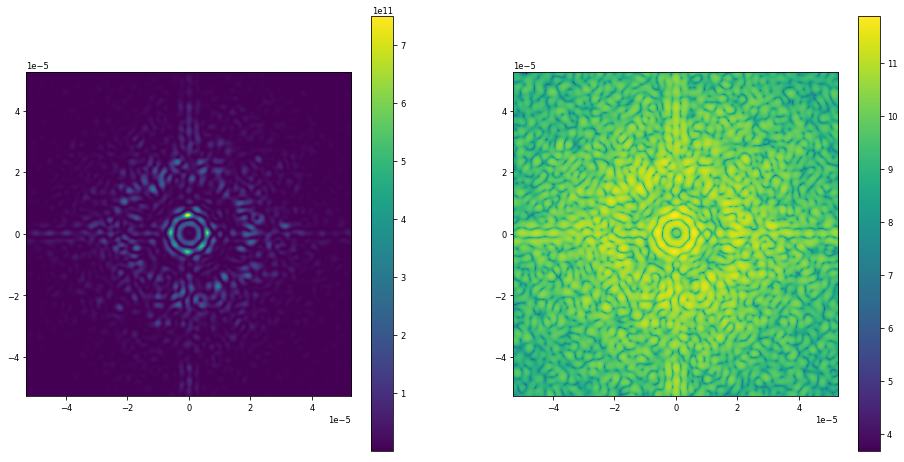

In [13]:


focal_wf_ref = Wavefront(Field(np.ones(pupil_grid.size), pupil_grid), wavelength)
focal_wf_ref.electric_field *= aperture
focal_wf_ref = prop(focal_wf_ref)


plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
imshow_field(Field(focal_wf_coro.intensity,focal_grid.scaled(D)))
plt.colorbar()

plt.subplot(1,2,2)
imshow_field(np.log10(Field(focal_wf_coro.intensity,focal_grid.scaled(D))))
plt.colorbar()

print(sum(focal_wf_coro.power[:]) / sum(focal_wf_ref.power[:]))


The next few codes apply an off-axis object onto the image.

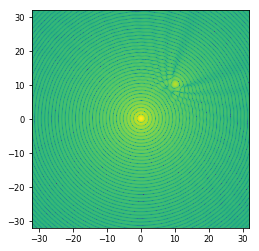

In [13]:

aper = circular_aperture(D)
aper = aper(pupil_grid) * np.exp(-1j * 0)

tilt=[10,10] #the off-aixs object is located in [10,10] lambda/D
phase_tilt = 2*np.pi * (pupil_grid.x / D * tilt[0] + pupil_grid.y / D * tilt[1])
aper *= np.exp(1j * phase_tilt)

wf_pla = Wavefront(aper,wavelength)
wf_pla.total_power = 0.01

wf_star = Wavefront(circular_aperture(D)(pupil_grid),wavelength)
wf_star.total_power = 1
wf_star.electric_field += wf_pla.electric_field

img0 = Field(prop(wf_star).intensity,focal_grid.scaled(D/wavelength))
imshow_field(np.log10(img0))


Now back to the coronagraphic pictures. We can make a long integration out of it, first of all let's construct a reference wavefront for strehl ratio.

In [15]:

wf_ref = Wavefront(Field(np.ones(pupil_grid.size), pupil_grid), wavelength)
wf_ref.total_power = 1
wf_ref.electric_field *= aperture
img_ref = prop(wf_ref).intensity


Here I only use a `NoiselessDetector`, no other noise will be introduced. If the presence of photon noise or flat, dark is wanted, then one should use the `NoisyDetector`.

The cadence mode I set is: each image is exposed for 1s, each integration step is 0.02s, and I only need one sample out of it. The `integration_time`, and `N_sample` can be changed in terms of your interest.

The `step` can be changed based on how fast you want to go. When make choices, take the coherence time of speckles ($\tau=0.31\frac{r_0}{V_0}$) into your consideration.

During the integration process, the performance of AO and the Strehl ratio will be shown all the time.





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Now the time is 0.04
CPU times: user 4.61 s, sys: 5.07 s, total: 9.68 s
Wall time: 2.67 s
CPU times: user 3.47 s, sys: 3.48 s, total: 6.94 s
Wall time: 1.64 s


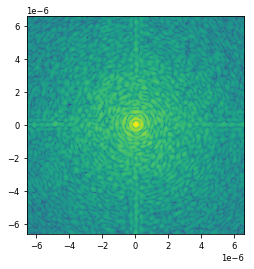

The Strehl ratio is 0.8469939026210279
Now the time is 0.06
CPU times: user 3.12 s, sys: 1.1 s, total: 4.22 s
Wall time: 722 ms
CPU times: user 2.64 s, sys: 43.9 ms, total: 2.68 s
Wall time: 451 ms


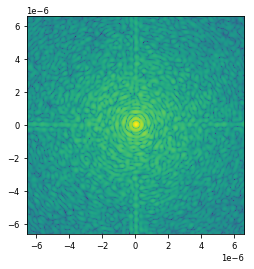

The Strehl ratio is 0.8564019776152708
Now the time is 0.08
CPU times: user 3.51 s, sys: 217 ms, total: 3.73 s
Wall time: 630 ms
CPU times: user 2.56 s, sys: 46.7 ms, total: 2.6 s
Wall time: 438 ms


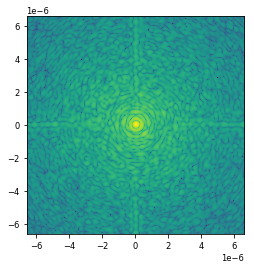

The Strehl ratio is 0.8548629717285606
Now the time is 0.1
CPU times: user 4.14 s, sys: 7.58 s, total: 11.7 s
Wall time: 3.03 s
CPU times: user 3.44 s, sys: 7.36 s, total: 10.8 s
Wall time: 3.07 s


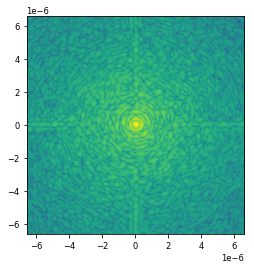

The Strehl ratio is 0.8420384531626111
Now the time is 0.12
CPU times: user 4.83 s, sys: 2.8 s, total: 7.63 s
Wall time: 2.12 s
CPU times: user 2.53 s, sys: 36.2 ms, total: 2.57 s
Wall time: 432 ms


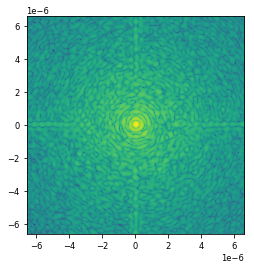

The Strehl ratio is 0.8524647255538068
Now the time is 0.14
CPU times: user 3.78 s, sys: 2.51 s, total: 6.29 s
Wall time: 1.51 s
CPU times: user 2.51 s, sys: 119 ms, total: 2.63 s
Wall time: 444 ms


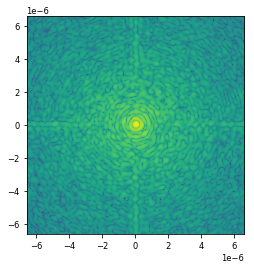

The Strehl ratio is 0.8438209769620993
Now the time is 0.16
CPU times: user 3.3 s, sys: 49.3 ms, total: 3.35 s
Wall time: 568 ms
CPU times: user 2.8 s, sys: 194 ms, total: 3 s
Wall time: 530 ms


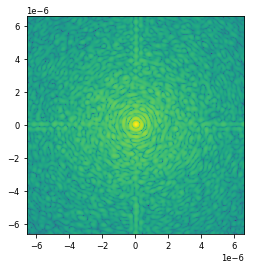

The Strehl ratio is 0.8576827607277069
Now the time is 0.18000000000000002
CPU times: user 3.52 s, sys: 71.7 ms, total: 3.59 s
Wall time: 605 ms
CPU times: user 2.66 s, sys: 33.1 ms, total: 2.7 s
Wall time: 454 ms


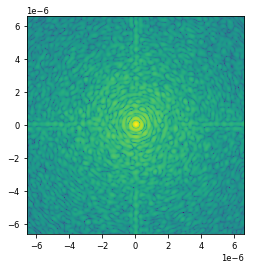

The Strehl ratio is 0.8624900207696733
Now the time is 0.2
CPU times: user 3.72 s, sys: 118 ms, total: 3.84 s
Wall time: 658 ms
CPU times: user 2.8 s, sys: 657 ms, total: 3.45 s
Wall time: 761 ms


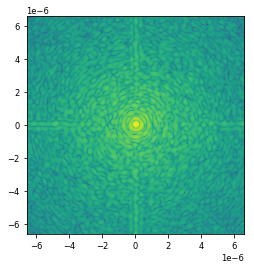

The Strehl ratio is 0.8559127242798732
Now the time is 0.22
CPU times: user 3.25 s, sys: 859 ms, total: 4.11 s
Wall time: 706 ms
CPU times: user 2.48 s, sys: 41.6 ms, total: 2.52 s
Wall time: 430 ms


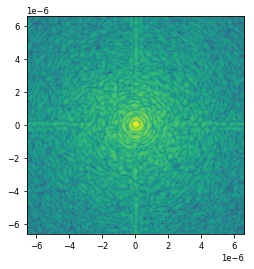

The Strehl ratio is 0.8672764668383289
Now the time is 0.24000000000000002
CPU times: user 3.41 s, sys: 193 ms, total: 3.6 s
Wall time: 620 ms
CPU times: user 2.57 s, sys: 43.7 ms, total: 2.61 s
Wall time: 441 ms


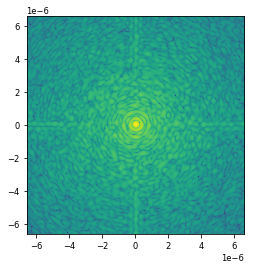

The Strehl ratio is 0.8679497789468428
Now the time is 0.26
CPU times: user 3.66 s, sys: 61.8 ms, total: 3.72 s
Wall time: 630 ms
CPU times: user 2.6 s, sys: 37.5 ms, total: 2.64 s
Wall time: 446 ms


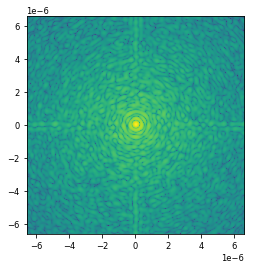

The Strehl ratio is 0.8593348097607811
Now the time is 0.27999999999999997
CPU times: user 3.48 s, sys: 57.9 ms, total: 3.54 s
Wall time: 601 ms
CPU times: user 3.59 s, sys: 171 ms, total: 3.76 s
Wall time: 741 ms


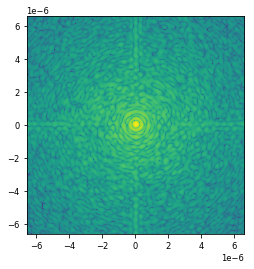

The Strehl ratio is 0.8712961010466724
Now the time is 0.3
CPU times: user 3.4 s, sys: 560 ms, total: 3.96 s
Wall time: 670 ms
CPU times: user 2.49 s, sys: 355 ms, total: 2.84 s
Wall time: 483 ms


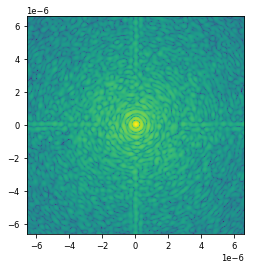

The Strehl ratio is 0.8724883794268314
Now the time is 0.32
CPU times: user 3.51 s, sys: 50.7 ms, total: 3.56 s
Wall time: 601 ms
CPU times: user 2.69 s, sys: 39.7 ms, total: 2.73 s
Wall time: 461 ms


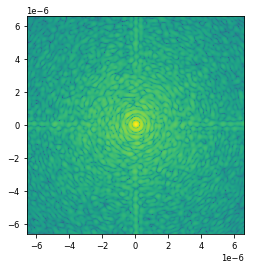

The Strehl ratio is 0.8654958161855348
Now the time is 0.33999999999999997
CPU times: user 3.49 s, sys: 1.55 s, total: 5.04 s
Wall time: 1.1 s
CPU times: user 2.52 s, sys: 71.1 ms, total: 2.59 s
Wall time: 436 ms


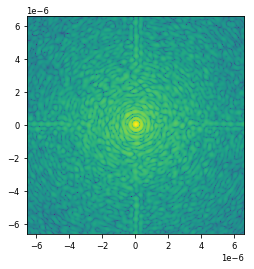

The Strehl ratio is 0.8754728918762789
Now the time is 0.36
CPU times: user 3.4 s, sys: 87.7 ms, total: 3.49 s
Wall time: 592 ms
CPU times: user 2.54 s, sys: 120 ms, total: 2.66 s
Wall time: 465 ms


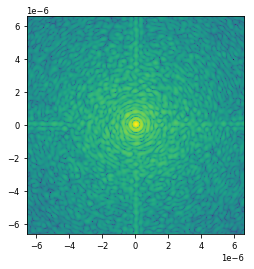

The Strehl ratio is 0.8739549846844292
Now the time is 0.38
CPU times: user 3.43 s, sys: 49.5 ms, total: 3.48 s
Wall time: 587 ms
CPU times: user 2.65 s, sys: 37.7 ms, total: 2.69 s
Wall time: 451 ms


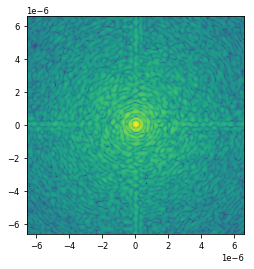

The Strehl ratio is 0.8651683184305153
Now the time is 0.39999999999999997
CPU times: user 3.42 s, sys: 42 ms, total: 3.47 s
Wall time: 585 ms
CPU times: user 2.71 s, sys: 29.7 ms, total: 2.74 s
Wall time: 459 ms


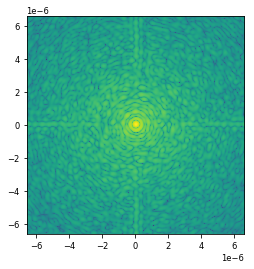

The Strehl ratio is 0.8725952449754226
Now the time is 0.42
CPU times: user 3.55 s, sys: 44.7 ms, total: 3.6 s
Wall time: 603 ms
CPU times: user 2.68 s, sys: 29.8 ms, total: 2.71 s
Wall time: 456 ms


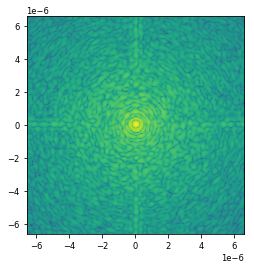

The Strehl ratio is 0.8631806717694536
Now the time is 0.44
CPU times: user 3.48 s, sys: 53.6 ms, total: 3.54 s
Wall time: 599 ms
CPU times: user 2.64 s, sys: 34.7 ms, total: 2.67 s
Wall time: 449 ms


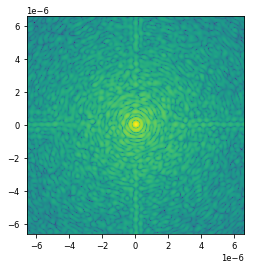

The Strehl ratio is 0.8748997196193663
Now the time is 0.45999999999999996
CPU times: user 3.22 s, sys: 58.8 ms, total: 3.28 s
Wall time: 553 ms
CPU times: user 2.83 s, sys: 352 ms, total: 3.19 s
Wall time: 603 ms


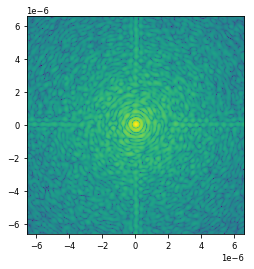

The Strehl ratio is 0.8777369451516465
Now the time is 0.48
CPU times: user 3.49 s, sys: 183 ms, total: 3.67 s
Wall time: 620 ms
CPU times: user 2.65 s, sys: 44 ms, total: 2.69 s
Wall time: 457 ms


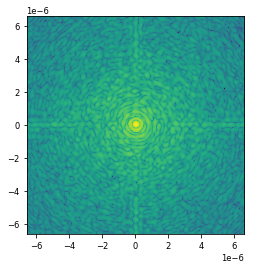

The Strehl ratio is 0.8688039885551503
Now the time is 0.5
CPU times: user 3.6 s, sys: 52.6 ms, total: 3.65 s
Wall time: 617 ms
CPU times: user 2.71 s, sys: 37.6 ms, total: 2.74 s
Wall time: 462 ms


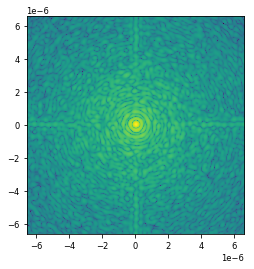

The Strehl ratio is 0.8787783412532449
Now the time is 0.52
CPU times: user 3.58 s, sys: 64.4 ms, total: 3.65 s
Wall time: 618 ms
CPU times: user 2.59 s, sys: 41 ms, total: 2.63 s
Wall time: 445 ms


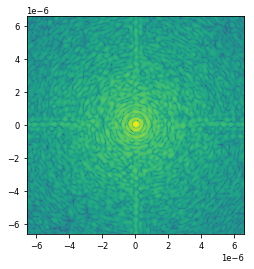

The Strehl ratio is 0.8856154176727378
Now the time is 0.54
CPU times: user 4.56 s, sys: 1.79 s, total: 6.36 s
Wall time: 1.45 s
CPU times: user 2.57 s, sys: 121 ms, total: 2.69 s
Wall time: 456 ms


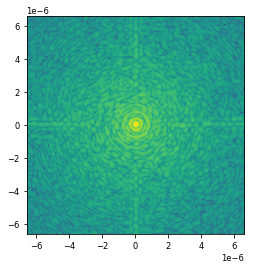

The Strehl ratio is 0.8795320696268498
Now the time is 0.56
CPU times: user 3.46 s, sys: 266 ms, total: 3.73 s
Wall time: 628 ms
CPU times: user 2.62 s, sys: 43.8 ms, total: 2.67 s
Wall time: 450 ms


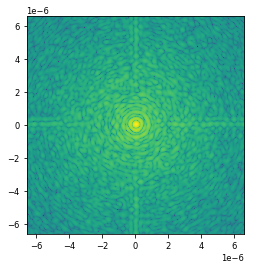

The Strehl ratio is 0.88529903323278
Now the time is 0.5800000000000001
CPU times: user 3.56 s, sys: 58.5 ms, total: 3.62 s
Wall time: 611 ms
CPU times: user 2.7 s, sys: 38 ms, total: 2.74 s
Wall time: 460 ms


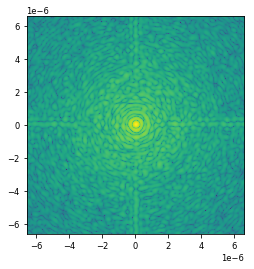

The Strehl ratio is 0.8859739648585612
Now the time is 0.6000000000000001
CPU times: user 3.55 s, sys: 62.3 ms, total: 3.61 s
Wall time: 611 ms
CPU times: user 2.59 s, sys: 46.5 ms, total: 2.64 s
Wall time: 448 ms


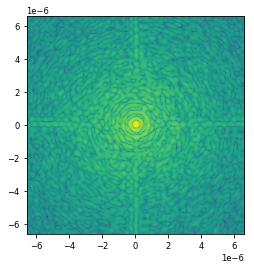

The Strehl ratio is 0.8813561731226993
Now the time is 0.62
CPU times: user 3.25 s, sys: 373 ms, total: 3.63 s
Wall time: 668 ms
CPU times: user 2.57 s, sys: 118 ms, total: 2.69 s
Wall time: 460 ms


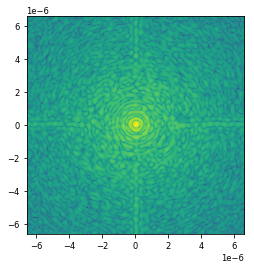

The Strehl ratio is 0.8901735121691039
Now the time is 0.64
CPU times: user 3.51 s, sys: 69.5 ms, total: 3.58 s
Wall time: 605 ms
CPU times: user 2.67 s, sys: 32.8 ms, total: 2.7 s
Wall time: 453 ms


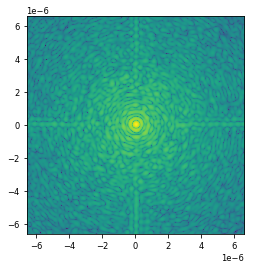

The Strehl ratio is 0.880007276162461
Now the time is 0.66
CPU times: user 3.49 s, sys: 54.7 ms, total: 3.54 s
Wall time: 601 ms
CPU times: user 2.58 s, sys: 41.4 ms, total: 2.62 s
Wall time: 443 ms


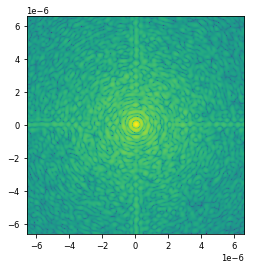

The Strehl ratio is 0.8831808120232725
Now the time is 0.68
CPU times: user 3.43 s, sys: 55.4 ms, total: 3.48 s
Wall time: 587 ms
CPU times: user 2.59 s, sys: 38.5 ms, total: 2.62 s
Wall time: 442 ms


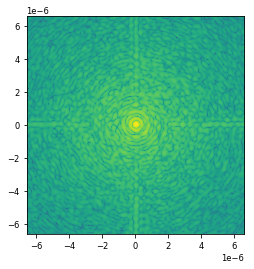

The Strehl ratio is 0.8835859880251555
Now the time is 0.7000000000000001
CPU times: user 3.62 s, sys: 71.8 ms, total: 3.69 s
Wall time: 626 ms
CPU times: user 2.6 s, sys: 34.3 ms, total: 2.63 s
Wall time: 442 ms


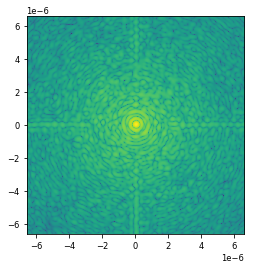

The Strehl ratio is 0.8771161785120412
Now the time is 0.7200000000000001
CPU times: user 3.55 s, sys: 62.6 ms, total: 3.61 s
Wall time: 612 ms
CPU times: user 2.65 s, sys: 33.2 ms, total: 2.69 s
Wall time: 451 ms


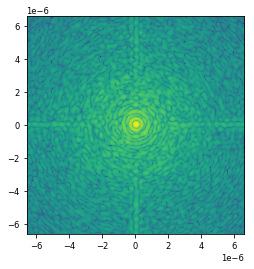

The Strehl ratio is 0.8875036914967689
Now the time is 0.7400000000000001
CPU times: user 3.6 s, sys: 59.6 ms, total: 3.66 s
Wall time: 616 ms
CPU times: user 2.57 s, sys: 49.5 ms, total: 2.62 s
Wall time: 442 ms


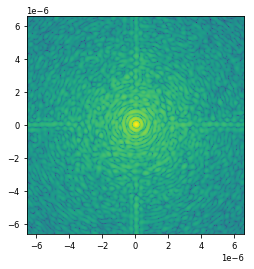

The Strehl ratio is 0.8890004535512923
Now the time is 0.76
CPU times: user 4.27 s, sys: 1.05 s, total: 5.32 s
Wall time: 985 ms
CPU times: user 3.31 s, sys: 1.18 s, total: 4.49 s
Wall time: 895 ms


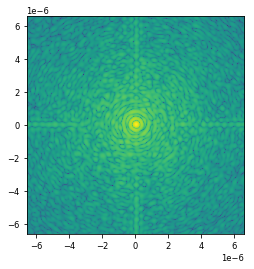

The Strehl ratio is 0.8830090738768198
Now the time is 0.78
CPU times: user 3.18 s, sys: 3.03 s, total: 6.21 s
Wall time: 1.17 s
CPU times: user 2.48 s, sys: 68.2 ms, total: 2.55 s
Wall time: 427 ms


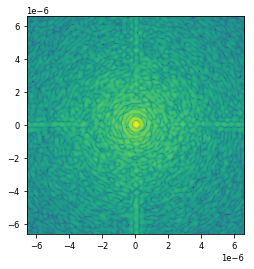

The Strehl ratio is 0.8897257929385357
Now the time is 0.8
CPU times: user 3.5 s, sys: 69.6 ms, total: 3.57 s
Wall time: 605 ms
CPU times: user 2.63 s, sys: 51 ms, total: 2.68 s
Wall time: 454 ms


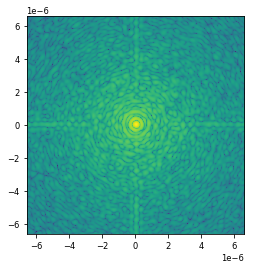

The Strehl ratio is 0.8887060612940861
Now the time is 0.8200000000000001
CPU times: user 3.37 s, sys: 49.5 ms, total: 3.42 s
Wall time: 573 ms
CPU times: user 2.69 s, sys: 31.6 ms, total: 2.72 s
Wall time: 456 ms


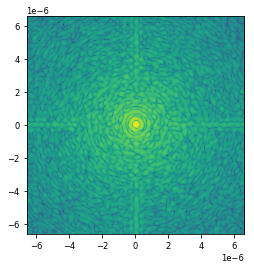

The Strehl ratio is 0.8838271504615302
Now the time is 0.8400000000000001
CPU times: user 3.47 s, sys: 47.1 ms, total: 3.52 s
Wall time: 591 ms
CPU times: user 2.61 s, sys: 33.6 ms, total: 2.65 s
Wall time: 443 ms


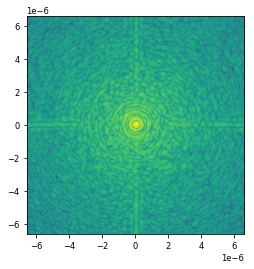

The Strehl ratio is 0.8970004467994426
Now the time is 0.8600000000000001
CPU times: user 3.57 s, sys: 64.8 ms, total: 3.63 s
Wall time: 612 ms
CPU times: user 2.58 s, sys: 47.3 ms, total: 2.62 s
Wall time: 443 ms


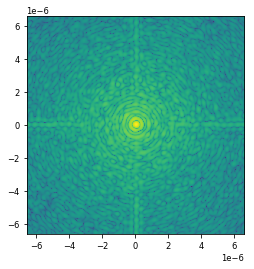

The Strehl ratio is 0.8997900809493851
Now the time is 0.88
CPU times: user 3.52 s, sys: 389 ms, total: 3.91 s
Wall time: 704 ms
CPU times: user 2.65 s, sys: 89.2 ms, total: 2.74 s
Wall time: 465 ms


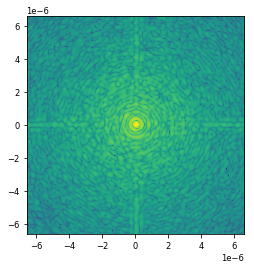

The Strehl ratio is 0.8929425995332165
Now the time is 0.9
CPU times: user 3.32 s, sys: 139 ms, total: 3.46 s
Wall time: 580 ms
CPU times: user 2.74 s, sys: 32.7 ms, total: 2.77 s
Wall time: 464 ms


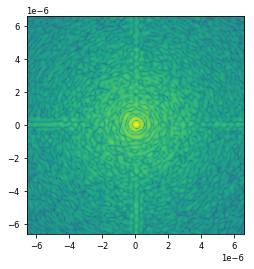

The Strehl ratio is 0.9040691889483069
Now the time is 0.92
CPU times: user 3.53 s, sys: 49.4 ms, total: 3.58 s
Wall time: 600 ms
CPU times: user 2.66 s, sys: 30.6 ms, total: 2.7 s
Wall time: 451 ms


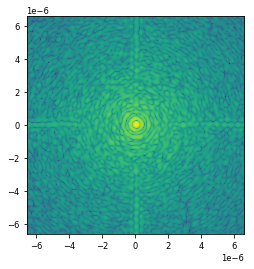

The Strehl ratio is 0.9014706383521354
Now the time is 0.9400000000000001
CPU times: user 3.38 s, sys: 43 ms, total: 3.43 s
Wall time: 574 ms
CPU times: user 2.62 s, sys: 29.8 ms, total: 2.65 s
Wall time: 443 ms


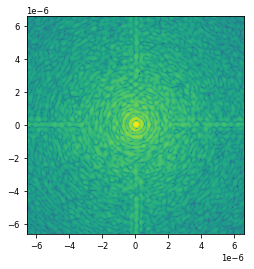

The Strehl ratio is 0.9095175206920769
Now the time is 0.9600000000000001
CPU times: user 3.54 s, sys: 44.4 ms, total: 3.58 s
Wall time: 600 ms
CPU times: user 2.72 s, sys: 30.9 ms, total: 2.75 s
Wall time: 460 ms


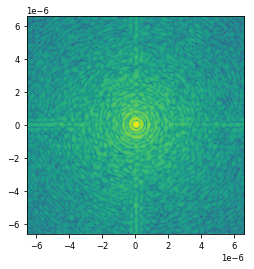

The Strehl ratio is 0.9104823445546976
Now the time is 0.9800000000000001
CPU times: user 3.59 s, sys: 49.4 ms, total: 3.64 s
Wall time: 609 ms
CPU times: user 2.68 s, sys: 27.3 ms, total: 2.7 s
Wall time: 452 ms


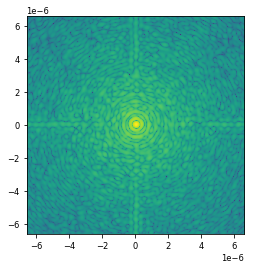

The Strehl ratio is 0.9062978587316012
Now the time is 1.0
CPU times: user 3.49 s, sys: 61.2 ms, total: 3.55 s
Wall time: 599 ms
CPU times: user 2.83 s, sys: 48.3 ms, total: 2.88 s
Wall time: 488 ms


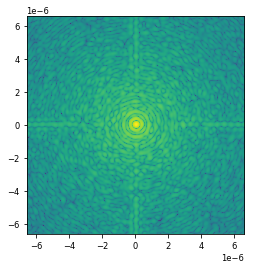

The Strehl ratio is 0.9145822329776401
Now the time is 1.02
CPU times: user 3.43 s, sys: 348 ms, total: 3.78 s
Wall time: 698 ms
CPU times: user 2.55 s, sys: 73.1 ms, total: 2.62 s
Wall time: 476 ms


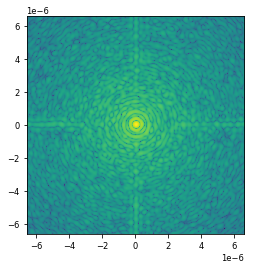

The Strehl ratio is 0.916430970259466
Now the time is 1.04
CPU times: user 3.13 s, sys: 570 ms, total: 3.7 s
Wall time: 627 ms
CPU times: user 2.43 s, sys: 436 ms, total: 2.87 s
Wall time: 484 ms


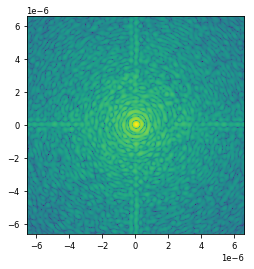

The Strehl ratio is 0.9088593780853379
CPU times: user 9min 49s, sys: 59.1 s, total: 10min 48s
Wall time: 1min 59s


In [16]:
%%time

integration_time = 1 #second

N_sample = 1

step = 0.02 # s

start_time = atmosphere.t + step

end_time = start_time + integration_time * N_sample


for t in np.linspace(start_time , end_time, integration_time * N_sample/step+1):

    print('Now the time is '+str(t))
    
    plt.clf()
    wf = Wavefront(Field(np.ones(pupil_grid.size), pupil_grid), wavelength)
    wf.total_power = 1
    %time atmosphere.evolve_until(t)
    %time wf2 = atmosphere.forward(wf)
    wf2.electric_field *= aperture
    img_ao = prop(wf2).intensity
    imshow_field(np.log10(img_ao))
    plt.draw()
    plt.pause(0.00001)
    
    wf2 = aberration(wf2)
    wf2 = prop.forward(wf2)
    wf2 = mask.forward(wf2)
    lyot = prop.backward(wf2)
    lyot = lyot_stop.forward(lyot)
    focal_wf = prop(lyot)
    print('The Strehl ratio is ' + str(img_ao.max()/img_ref.max()))
    detector.integrate(focal_wf , step)

    
    if t in np.linspace(start_time + integration_time , end_time, N_sample):
        img = detector.read_out()
        #This step save the integrated images as a FITS file
        #field2array(img,'ispeckles'+str(t)+'.fits')
        
        
        
        

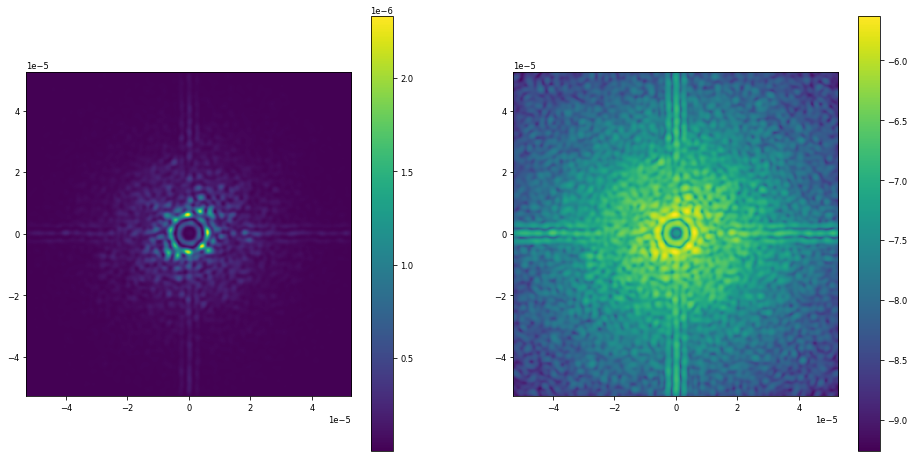

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
imshow_field(Field(img,focal_grid.scaled(D)))
plt.colorbar()


plt.subplot(1,2,2)
imshow_field(Field(np.log10(img),focal_grid.scaled(D)))
plt.colorbar()

This is used to see the contrast profile of the image.

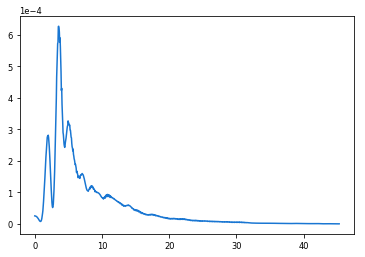

In [19]:

wf_ref = Wavefront(Field(np.ones(pupil_grid.size), pupil_grid), wavelength)

wf_ref.total_power = 1

wf_ref.electric_field *= aperture

detector_ref.integrate(prop(wf_ref),integration_time)

im_Ref = detector_ref.read_out()

x,y,rms,sample = radial_profile(Field(img / im_Ref.max(),focal_grid.scaled(D/wavelength)),0.05)

plt.plot(x,y)